In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, get_scheduler
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import io

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
num_labels = 16
samples_per_class_train = 100
samples_per_class_eval = 10

In [5]:
class CustomDataset(IterableDataset):
    def __init__(self, dataset_name, split, feature_extractor, samples_per_class, subset='train'):
        self.dataset_name = dataset_name
        self.split = split
        self.feature_extractor = feature_extractor
        self.samples_per_class = samples_per_class
        self.subset = subset
        self.samples_collected = {label: 0 for label in range(num_labels)}
        self.dataset_stream = self.create_stream()

    def create_stream(self):
        return load_dataset(self.dataset_name, split=self.split, streaming=True)

    def reset_stream(self):
        self.dataset_stream = self.create_stream()
        self.samples_collected = {label: 0 for label in range(num_labels)}

    def preprocess(self, example):
        if isinstance(example['image'], bytes):
            image = Image.open(io.BytesIO(example['image']))
        else:
            image = example['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')

        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze()
        return pixel_values, example['label']

    def __iter__(self):
        for example in self.dataset_stream:
            label = example['label']
            if self.samples_collected[label] < self.samples_per_class:
                self.samples_collected[label] += 1
                yield self.preprocess(example)
            if all(value == self.samples_per_class for value in self.samples_collected.values()):
                break

In [6]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/dit-base")

preprocessor_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/beit/image_processing_beit.py:110: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [7]:
train_dataset = CustomDataset("rvl_cdip", 'train', feature_extractor, samples_per_class_train, subset='train')
eval_dataset = CustomDataset("rvl_cdip", 'test', feature_extractor, samples_per_class_eval, subset='eval')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for rvl_cdip contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rvl_cdip
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

In [9]:
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base", num_labels=num_labels)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 3
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): BeitIntermediate(
            (dense): Linear(in_featur

In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    train_dataset.reset_stream()
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch in progress_bar:
        pixel_values, labels = batch
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        outputs = model(pixel_values)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    if num_batches == 0:
        raise RuntimeError(f"No batches processed in epoch {epoch + 1}. Check your data streaming and dataset implementation.")

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}")

    scheduler.step()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for rvl_cdip contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rvl_cdip
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Epoch 1/3: 0it [00:00, ?it/s]

Epoch 1/3, Average Loss: 2.02516887024045


Epoch 2/3: 0it [00:00, ?it/s]

Epoch 2/3, Average Loss: 1.091572993695736


Epoch 3/3: 0it [00:00, ?it/s]

Epoch 3/3, Average Loss: 0.9270744317024946


In [13]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for pixel_values, labels in eval_dataloader:
        pixel_values, labels = pixel_values.to(device), labels.to(device)
        outputs = model(pixel_values)
        predictions = torch.argmax(outputs.logits, dim=-1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

In [14]:
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_labels)]))

              precision    recall  f1-score   support

     Class 0       0.56      0.90      0.69        10
     Class 1       0.36      0.40      0.38        10
     Class 2       0.82      0.90      0.86        10
     Class 3       0.89      0.80      0.84        10
     Class 4       0.73      0.80      0.76        10
     Class 5       0.50      0.20      0.29        10
     Class 6       0.82      0.90      0.86        10
     Class 7       1.00      0.60      0.75        10
     Class 8       0.90      0.90      0.90        10
     Class 9       0.78      0.70      0.74        10
    Class 10       0.62      0.50      0.56        10
    Class 11       0.62      0.80      0.70        10
    Class 12       0.54      0.70      0.61        10
    Class 13       1.00      0.80      0.89        10
    Class 14       0.71      0.50      0.59        10
    Class 15       0.69      0.90      0.78        10

    accuracy                           0.71       160
   macro avg       0.72   

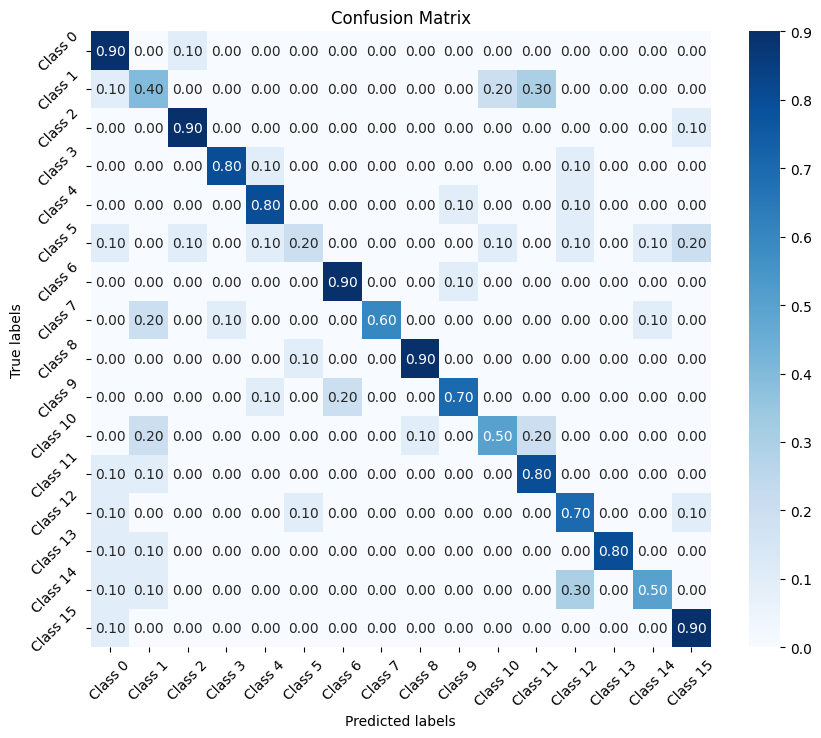

In [16]:
plt.figure(figsize=(10, 8))  # Increase figure size

cm = confusion_matrix(all_labels, all_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=[f'Class {i}' for i in range(num_labels)],
            yticklabels=[f'Class {i}' for i in range(num_labels)])

plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=45)  # Rotate y-axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')  # Optional: add a title for clarity
plt.show()
